In [1]:
import cv2
# import pytesseract
# from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [2]:
def find_number(img):
    
    # detecting and classifying number in the boxes based on number of contours detected
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    
    _, contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) == 3:
        return 0
    elif len(contours) == 2:
        return 1

def find_building_matrix(path):
    
    # Read the image and convert to gray and binary for later use
    image = cv2.imread(path)  
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) 
    bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    plt.imshow(bw, cmap = 'gray')
    plt.show()
    
    result =  np.zeros_like(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    #plt.imshow(thresh, cmap = 'gray')
    #plt.show()
    
    # Detecting horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
    remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    plt.imshow(remove_horizontal, cmap = 'gray')
    plt.show()
    
    cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(result, [c], -1, (255,255,255), 5)
    
    # Detecting vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
    remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    plt.imshow(remove_vertical, cmap = 'gray')
    plt.show()
    cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(result, [c], -1, (255,255,255), 5)
    
    # final_image after detecting vertical and horizontal lines
    plt.imshow(result, cmap = 'gray')
    plt.show() 
    
    # detecting square boxes of the grid obtained from the above image
    _, contours, hierarchy = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    x_dim = []   # for storing unique x coordinates to find total number of flats on a floor
    y_dim = []   # for storing unique y coordinates to find total number of floors
    results_dict = {}   # for storing all the detections of boxes and the number inside them
    
    for i,cnt in enumerate(contours):
        
        blank = np.zeros_like(gray)        
        if hierarchy[0][i][3]==0:
            
            x,y,w,h = cv2.boundingRect(cnt)
            if x not in x_dim:
                x_dim.append(x)
            if y not in y_dim:
                y_dim.append(y)
            
            cv2.rectangle(blank, (x, y), (x+w, y+h), (255), -1)
            
            blank = cv2.bitwise_and(blank,bw)
            ROI = blank[y:y+h, x:x+w]   # separating region of interests of individual grids & detecting number in it
            
            detection = find_number(ROI)   # find number inside the region of interest
            results_dict[(x,y)] = detection  # storing the detected number with its position in image 
   

    # Creating the building map matrix based on the location of number found 

    x_dim = sorted(x_dim)
    y_dim = sorted(y_dim)
    
    final_array = []
    
    
    for i in y_dim:
        temp = []
        for j in x_dim:
            temp.append(results_dict[(j,i)])
        final_array.append(temp)
        
    return np.array(final_array)

In [3]:
def process_row(orig_row, sum_row):
    # function to calculate cost of a floor and individual flats by adding up the top floor costs
        
    n_flats = len(orig_row)
    index_of_1 = [i for i in range(len(orig_row)) if orig_row[i]>0]

    ind0 = index_of_1[0]
    while ind0>0:
        sum_row[ind0-1] = sum_row[ind0]+1
        ind0 -= 1

    ind_last = index_of_1[-1]
    while ind_last < n_flats-1:
        sum_row[ind_last+1] = sum_row[ind_last]+1
        ind_last += 1

    for i in range(0, len(index_of_1)-1):
        start = index_of_1[i]
        end = index_of_1[i+1]

        while start < end-1:                
            sum_row[start+1] = sum_row[start]+1
            start += 1

        while sum_row[end] + 1< sum_row[end-1]:
            sum_row[end-1] = sum_row[end] + 1
            end -= 1

    return (sum_row)     

def calculate_cost_array(array_):
    # A function to find the cost matrix of the building based on its map of floor and flat
    dp = np.zeros_like(array_)
    flats = len(array_[0])
    floors = len(array_)            
        
    for i in range(1, floors):
        
        dp[i] = dp[i-1]*array_[i] + array_[i]  
        dp[i] = process_row(array_[i], dp[i])
    
    return dp

def min_traversal_value(user, cost_array):
    total_floors = len(list(cost_array))
    user_floor = total_floors - 1 - user[0]
    user_flat = user[1]
    return cost_array[user_floor, user_flat]
    

In [4]:
def pipeline(image_path, user_location):
    # get building map of floor and flats based on number detection and localization
    building_map_array = find_building_matrix(image_path)
    print('building map')
    print(building_map_array)
    # get cost of traveling from each flat of each floor to top floor
    cost_matrix = calculate_cost_array(building_map_array)
    print('cost matrix')
    print(cost_matrix)
    # based on user location  return the min cost of trversal
    min_flat = min_traversal_value(user_location, cost_matrix)
    return (min_flat)

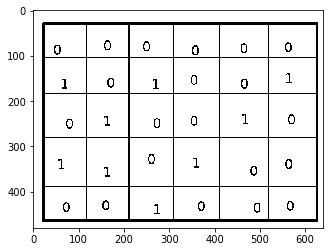

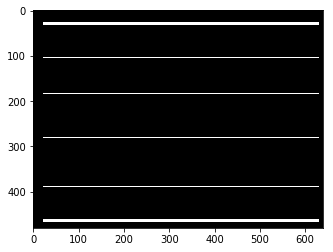

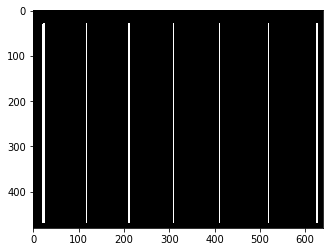

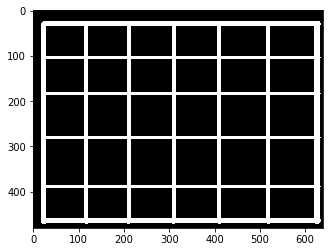

building map
[[0 0 0 0 0 0]
 [1 0 1 0 0 1]
 [0 1 0 0 1 0]
 [1 1 0 1 0 0]
 [0 0 1 0 0 0]]
cost matrix
[[0 0 0 0 0 0]
 [1 2 1 2 2 1]
 [4 3 4 4 3 4]
 [5 4 5 5 6 7]
 [8 7 6 7 8 9]]


6

In [5]:
pipeline('test.png',[0,2])